In [4]:
!pip install snntorch

### Importing the Necessary Libraries

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import utils, nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
import snntorch as snn
from snntorch import surrogate
import snntorch.functional as SF

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

Device in use: cuda


### Data Loading and Preprocessing

In [7]:
X_train = np.load("/kaggle/input/kth-compressed/X_train_kth.npy")
X_val = np.load("/kaggle/input/kth-compressed/X_val_kth.npy")
X_test = np.load("/kaggle/input/kth-compressed/X_test_kth.npy")

y_train = np.load("/kaggle/input/kth-compressed/y_train_kth.npy")
y_val = np.load("/kaggle/input/kth-compressed/y_val_kth.npy")
y_test = np.load("/kaggle/input/kth-compressed/y_test_kth.npy")

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1560, 32, 64, 64) (390, 32, 64, 64) (345, 32, 64, 64)
(1560,) (390,) (345,)


In [8]:
print(X_train.min(), X_train.max())
print(X_val.min(), X_val.max())
print(X_test.min(), X_test.max())

0.00073529413 1.0
0.0009803922 1.0
0.0037990196 1.0


In [9]:
CATEGORIES = {
    "boxing": 0,
    "handclapping": 1,
    "handwaving": 2,
    "jogging": 3,
    "running": 4,
    "walking": 5
}

reverse_category_map = {val : key for key, val in CATEGORIES.items()}
print(reverse_category_map)

{0: 'boxing', 1: 'handclapping', 2: 'handwaving', 3: 'jogging', 4: 'running', 5: 'walking'}


### Data Visualization

In [10]:
def plot_sample(frame = 12, idx = None):
    if idx == None:
        idx = np.random.randint(X_train.shape[0])
    img_, label_ =  X_train[idx][frame], reverse_category_map[y_train[idx]]
    plt.axis('off')
    plt.title(f"Label: {label_} | Frame: {frame}")
    plt.imshow(img_, cmap = "gray")

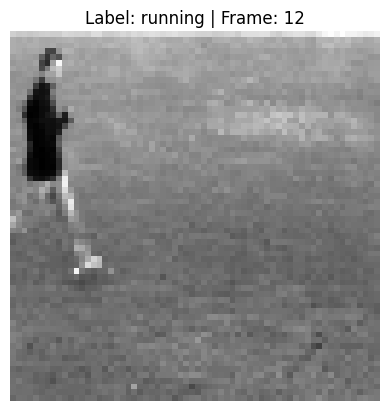

In [11]:
plot_sample()

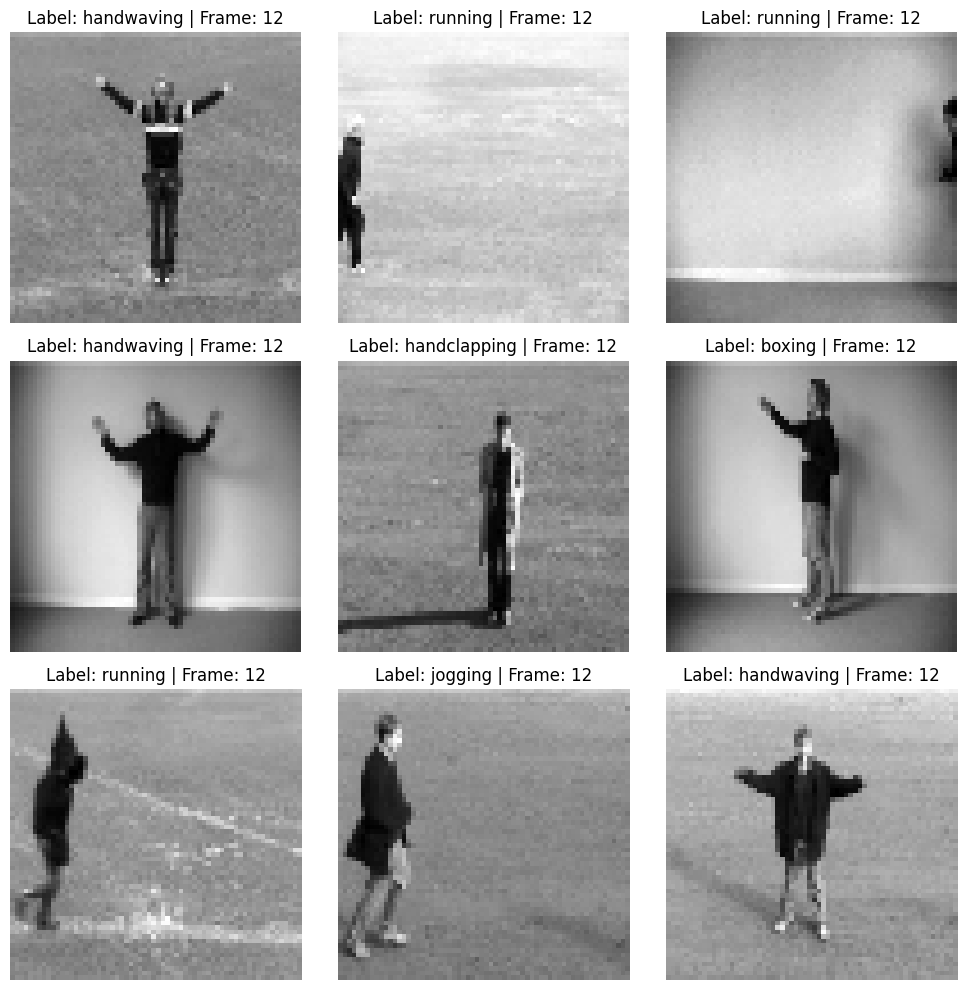

In [12]:
plt.figure(figsize = (10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plot_sample()
plt.tight_layout()
plt.show()

In [13]:
X_train = X_train.reshape(X_train.shape[0], 1, 32, 64, 64)
X_val = X_val.reshape(X_val.shape[0], 1, 32, 64, 64)
X_test = X_test.reshape(X_test.shape[0], 1, 32, 64, 64)

print(X_train.shape, X_val.shape, X_test.shape)

(1560, 1, 32, 64, 64) (390, 1, 32, 64, 64) (345, 1, 32, 64, 64)


In [14]:
X_train_ = torch.tensor(X_train).float()
X_val_ = torch.tensor(X_val).float()
X_test_ = torch.tensor(X_test).float()

y_train_ = torch.tensor(y_train).long() 
y_val_ = torch.tensor(y_val).long()
y_test_ = torch.tensor(y_test).long()

print(X_train_.shape, X_val_.shape, X_test_.shape)

torch.Size([1560, 1, 32, 64, 64]) torch.Size([390, 1, 32, 64, 64]) torch.Size([345, 1, 32, 64, 64])


In [15]:
train_dataset = TensorDataset(X_train_, y_train_)
val_dataset = TensorDataset(X_val_, y_val_)
test_dataset = TensorDataset(X_test_, y_test_)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [16]:
*_, last_set = iter(train_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(data.shape, targets.shape)  # 1560 % batch_size

*_, last_set = iter(val_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(data.shape, targets.shape)  # 390 % batch_size

*_, last_set = iter(test_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(data.shape, targets.shape)  # 345 % batch_size

torch.Size([24, 1, 32, 64, 64]) torch.Size([24])
torch.Size([6, 1, 32, 64, 64]) torch.Size([6])
torch.Size([25, 1, 32, 64, 64]) torch.Size([25])


### Defining the Convolutional SNN Architecture

In [17]:
beta = 0.9  # Decay
spike_gradient = surrogate.fast_sigmoid(slope = 25)
num_steps = 6
epoch_num = 10

In [18]:
class SNN_model(nn.Module):
    def __init__(self, num_steps, input_channel = 1):
        super(SNN_model, self).__init__()
        self.num_steps = num_steps
        self.conv1 = nn.Conv3d(input_channel, 64, 5, 1, 2)
        self.lif1 = snn.Leaky(beta = beta, spike_grad = spike_gradient)
        self.pool = nn.AvgPool3d(2)
        self.conv2 = nn.Conv3d(64, 128, 5, 1, 2)
        self.lif2 = snn.Leaky(beta = beta, spike_grad = spike_gradient)
        self.fc1 = nn.Linear(262144, 6)
        self.lif3 = snn.Leaky(beta = beta, spike_grad = spike_gradient)

    def forward(self, x):
        batch_size_curr = x.shape[0]
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []
        mem3_rec = []

        for step in range(self.num_steps):
            cur1 = self.pool(self.conv1(x))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.pool(self.conv2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc1(spk2.view(batch_size_curr, -1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec), torch.stack(mem3_rec)

In [19]:
snn_model = SNN_model(num_steps).to(device)
print(snn_model)
optimizer_snn = torch.optim.Adam(snn_model.parameters(), lr = 1e-2, betas = (0.9, 0.999))
loss_snn = nn.CrossEntropyLoss()

SNN_model(
  (conv1): Conv3d(1, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (lif1): Leaky()
  (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv3d(64, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (lif2): Leaky()
  (fc1): Linear(in_features=262144, out_features=6, bias=True)
  (lif3): Leaky()
)


In [20]:
def train_snn(network, train_dl, num_epochs, num_steps):
    loss_hist = []
    acc_hist = []
    for epoch in range(num_epochs):
        for i, (data, targets) in enumerate(iter(train_dl)):
            data = data.to(device)
            targets = targets.to(device)

            network.train()
            spk_rec, mem_rec = network(data)

            loss_val = torch.zeros((1), dtype = torch.float, device = device)
            for step in range(num_steps):
                loss_val += loss_snn(mem_rec[step], targets)

            optimizer_snn.zero_grad()
            loss_val.backward()
            optimizer_snn.step()

        loss_hist.append(loss_val.item())
        print(f"Epoch: {epoch + 1}\nTrain Loss: {loss_val.item():.2f}")
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")
    return loss_hist, acc_hist

In [29]:
# history = train_snn(snn_model, train_loader, epoch_num, num_steps)

In [ ]:
def test_snn(network, test_dl, num_steps):
    size, correct = 0, 0
    loss_val = 0
    with torch.no_grad():
        network.eval()
        for data, targets in test_dl:
            data = data.to(device)
            targets = targets.to(device)

            test_spk, test_mem = network(data)

            _, predicted = test_spk.sum(dim = 0).max(1)
            size += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss_val += loss_snn(test_mem[num_steps-1], targets)

    test_loss = loss_val / size
    print(f"Total correctly classified test set images: {correct} / {size}")
    print(f"Test set accuracy: {100 * correct / size:.2f}%, avg loss: {test_loss:>8f}")

In [ ]:
def train_snn_with_early_stopping(network, train_dl, test_dl, num_epochs, num_steps, patience = 5):
    loss_hist = []
    acc_hist = []
    best_acc = 0
    no_improvement_count = 0

    for epoch in range(num_epochs):
        for i, (data, targets) in enumerate(iter(train_dl)):
            data = data.to(device)
            targets = targets.to(device)

            network.train()
            spk_rec, mem_rec = network(data)

            loss_val = torch.zeros((1), dtype=torch.float, device=device)
            for step in range(num_steps):
                loss_val += loss_snn(mem_rec[step], targets)

            optimizer_snn.zero_grad()
            loss_val.backward()
            optimizer_snn.step()

            loss_hist.append(loss_val.item())

        print(f"Epoch: {epoch + 1} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        size, correct = 0, 0
        loss_val = 0
        with torch.no_grad():
            network.eval()
            for data, targets in test_dl:
                data = data.to(device)
                targets = targets.to(device)

                test_spk, test_mem = network(data)

                _, predicted = test_spk.sum(dim = 0).max(1)
                size += targets.size(0)
                correct += (predicted == targets).sum().item()
                loss_val += loss_snn(test_mem[num_steps - 1], targets)

        test_acc = 100 * correct / size
        print(f"Validation set accuracy: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            
        if no_improvement_count >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
    print(f"Best validation set accuracy: {best_acc:.2f}%")
    return loss_hist, acc_hist

In [28]:
# Training the model with Early Stopping

train_snn_with_early_stopping(snn_model, train_loader, val_loader, epoch_num, num_steps)

Epoch [1/50], Loss: 1.5009, Train Accuracy: 40.77%
Validation Accuracy: 56.67%
Best model saved.
Epoch [2/50], Loss: 0.7789, Train Accuracy: 68.59%
Validation Accuracy: 65.90%
Best model saved.
Epoch [3/50], Loss: 0.6047, Train Accuracy: 76.35%
Validation Accuracy: 78.46%
Best model saved.
Epoch [4/50], Loss: 0.5175, Train Accuracy: 80.51%
Validation Accuracy: 79.49%
Best model saved.
Epoch [5/50], Loss: 0.4312, Train Accuracy: 83.21%
Validation Accuracy: 80.00%
Best model saved.
Epoch [6/50], Loss: 0.3938, Train Accuracy: 85.32%
Validation Accuracy: 78.72%
Epoch [7/50], Loss: 0.3348, Train Accuracy: 87.56%
Validation Accuracy: 76.92%
Epoch [8/50], Loss: 0.3266, Train Accuracy: 87.95%
Validation Accuracy: 83.33%
Best model saved.
Epoch [9/50], Loss: 0.2606, Train Accuracy: 90.58%
Validation Accuracy: 87.18%
Best model saved.
Epoch [10/50], Loss: 0.2297, Train Accuracy: 91.73%
Validation Accuracy: 84.62%
Epoch [11/50], Loss: 0.2004, Train Accuracy: 93.14%
Validation Accuracy: 86.15%
Epo

/tmp/ipykernel_30/3732779727.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 84.64%


In [ ]:
def evaluate_model(network, test_dl, num_steps):
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        network.eval()
        for data, targets in test_dl:
            data = data.to(device)
            targets = targets.to(device)

            test_spk, _ = network(data)

            _, predicted = test_spk.sum(dim=0).max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Precision: {precision * 100:.2f}%")
    print(f"Test Recall: {recall * 100:.2f}%")
    print(f"Test F1-Score: {f1 * 100:.2f}%")
    
    return [all_targets, all_predictions]

/tmp/ipykernel_30/3121321461.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 84.64%

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.79      0.88        61
     Class 1       0.83      0.98      0.90        51
     Class 2       0.92      0.97      0.94        58
     Class 3       0.71      0.65      0.68        57
     Class 4       0.86      0.82      0.84        60
     Class 5       0.78      0.90      0.83        58

    accuracy                           0.85       345
   macro avg       0.85      0.85      0.85       345
weighted avg       0.85      0.85      0.84       345

Confusion Matrix:


<Axes: >

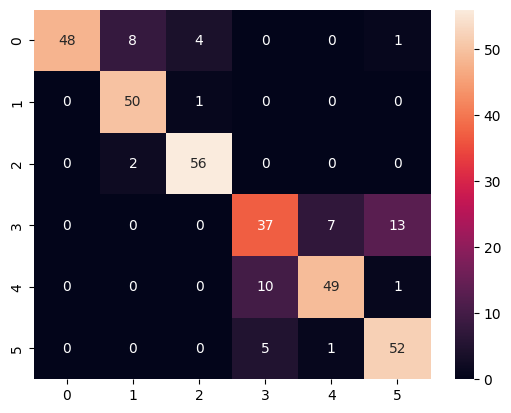

In [32]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\nClassification Report:")
print(metrics.classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(6)]))

conf_matrix = metrics.confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
sns.heatmap(conf_matrix, annot = True)